In [35]:
# Author: Rushikesh Sureshkumar Patel
# Student ID: 1001729170

# 3D Subject-level CNN on MRI Images

2 variations implemented:
1. Using Image resizing
2. Using Data Augmentation & Resizing

In [1]:
import nibabel as nib
import os
import itertools
import numpy as np
from nilearn import plotting
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

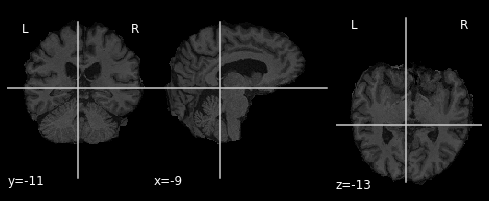

In [3]:
def read_nifti_file1(nifti_file):
    nii_image = nib.load(nifti_file)
    nii_data = nii_image.get_fdata()
    plotting.plot_anat(nii_image)
    return nii_data

read_nifti_file1(r".\Training\health\sub6\T1_bet_2_0413.nii.gz")

In [4]:
def read_nifti_file(nifti_file):
    nii_image = nib.load(nifti_file)
    nii_data = nii_image.get_fdata()
#     plotting.plot_anat(nii_image)
    return nii_data

def resize_data(data):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = 128
    new_size_y = 128
    new_size_z = 64
#     new_size_x = 116
#     new_size_y = 130
#     new_size_z = 83
    
    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data

def get_data(dtype = "Training" ,resize = True):
    
    healthy_subjects = []
    ad_patients = []
    
    if dtype == "Training":
        for i in range(1,10):
            healthy = read_nifti_file(".\\"+dtype+"\health\sub"+str(i)+"\T1_bet_2_0413.nii.gz")
            patient = read_nifti_file(".\\"+dtype+"\patient\sub"+str(i)+"\T1_bet_2_0413.nii.gz")
            if resize == True:
                healthy = resize_data(healthy)
                patient = resize_data(patient)

            healthy_subjects.append(healthy)
            ad_patients.append(patient)
    
    elif dtype == "Testing":
        for i in range(1,6):
            healthy = read_nifti_file(".\\"+dtype+"\health\sub"+str(i)+"\T1_bet_2_0413.nii.gz")
            patient = read_nifti_file(".\\"+dtype+"\patient\sub"+str(i)+"\T1_bet_2_0413.nii.gz")
            if resize == True:
                healthy = resize_data(healthy)
                patient = resize_data(patient)

            healthy_subjects.append(healthy)
            ad_patients.append(patient)
        
    return healthy_subjects,ad_patients

In [5]:
def flip_image(image):
    flipped_image = tf.image.flip_left_right(image)
    return flipped_image

def augmentation(list_of_data, count = 4):
    
    augmentated_data = list_of_data[:]
    indexes = np.arange(len(list_of_data))
    select_images = np.random.choice(indexes, count+1, replace = False)
    
    # Flipping random count number of images and appending it to the dataset  
    for i in select_images:
        augmentated_data.append(flip_image(list_of_data[i]))
    return augmentated_data

def data_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

In [6]:
def get_model(width=128, height=128, depth=64):
    """Building a 3D convolutional neural network model."""
#     141, 199, 190
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Defining the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model




In [7]:
# Get data and apply augmentation
healthy_subjects, patients = get_data(resize = True)


### Method 1: Using the resized images on model 

In [8]:
# augemented_healthy_subjects = augmentation(healthy_subjects, count = 6)
# augemented_patients = augmentation(patients, count = 6)

print("MRI healthy subjects: " + str(len(healthy_subjects)))
print("MRI un-healthy subjects: " + str(len(patients)))

MRI healthy subjects: 9
MRI un-healthy subjects: 9


In [9]:
# Assigning class labels
abnormal_labels = np.array([1 for _ in range(len(patients))])
normal_labels = np.array([0 for _ in range(len(healthy_subjects))])

x_train = []
y_train = []

x_train.extend(healthy_subjects)
x_train.extend(patients)
y_train.extend(normal_labels)
y_train.extend(abnormal_labels)

print("Number of samples in train are %d."% (len(x_train)))

Number of samples in train are 18.


In [10]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# test_dataset = (
#     test_loader.shuffle(len(x_test))
#     .map(data_preprocessing)
#     .batch(batch_size)
#     .prefetch(100)
# )

In [11]:
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

In [12]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


In [13]:
epochs = 50

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

history = model.fit(
    train_dataset,
#     validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
)

Train for 9 steps
Epoch 1/50
9/9 [==============================] - 19s 2s/step - loss: 0.9300 - acc: 0.3889
Epoch 2/50
9/9 [==============================] - 7s 764ms/step - loss: 0.8622 - acc: 0.5000
Epoch 3/50
9/9 [==============================] - 7s 765ms/step - loss: 0.7113 - acc: 0.6111
Epoch 4/50
9/9 [==============================] - 7s 765ms/step - loss: 0.9672 - acc: 0.5556
Epoch 5/50
9/9 [==============================] - 7s 768ms/step - loss: 0.5521 - acc: 0.7222
Epoch 6/50
9/9 [==============================] - 7s 781ms/step - loss: 0.8519 - acc: 0.5556
Epoch 7/50
9/9 [==============================] - 7s 771ms/step - loss: 0.4793 - acc: 0.8889
Epoch 8/50
9/9 [==============================] - 7s 765ms/step - loss: 0.7152 - acc: 0.5556
Epoch 9/50
9/9 [==============================] - 7s 757ms/step - loss: 0.5797 - acc: 0.6667
Epoch 10/50
9/9 [==============================] - 7s 764ms/step - loss: 0.7139 - acc: 0.5000
Epoch 11/50
9/9 [==============================] - 7s

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



In [14]:
sum(history.history['acc'])/len(history.history['acc']) # Avergae accuracy

0.6900000011920929

In [15]:
# Creating Validation Data set
test_h, test_p = get_data("Testing", resize = True)
test_abnormal_labels = np.array([1 for _ in range(len(test_p))])
test_normal_labels = np.array([1 for _ in range(len(test_h))])

In [16]:
x_test = []
y_test = []

x_test.extend(test_h)
x_test.extend(test_p)
y_test.extend(test_normal_labels)
y_test.extend(test_abnormal_labels)

In [17]:
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [18]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

5/5 - 2s - loss: 0.8571 - acc: 0.5000


In [45]:
test_acc

0.5

### Method 2: Data Augmentation & Resizing

In [19]:
# We already have the data we just need to call the augmentation function

# Adding 6 images from healthy as well as patient dataset
augemented_healthy_subjects = augmentation(healthy_subjects, count = 6)
augemented_patients = augmentation(patients, count = 6)

print("MRI healthy subjects: " + str(len(augemented_healthy_subjects)))
print("MRI un-healthy subjects: " + str(len(augemented_patients)))

MRI healthy subjects: 16
MRI un-healthy subjects: 16


In [20]:
abnormal_labels2 = np.array([1 for _ in range(len(augemented_patients))])
normal_labels2 = np.array([0 for _ in range(len(augemented_healthy_subjects))])

x_train2 = []
y_train2 = []

x_train2.extend(augemented_healthy_subjects)
x_train2.extend(augemented_patients)
y_train2.extend(normal_labels2)
y_train2.extend(abnormal_labels2)

print("Number of samples in train are %d."% (len(x_train2)))

Number of samples in train are 32.


In [29]:
train_loader2 = tf.data.Dataset.from_tensor_slices((x_train2, y_train2))
batch_size = 2
train_dataset2 = (
    train_loader.shuffle(len(x_train))
    .map(data_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


In [30]:
model2 = get_model()
model2.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 14, 64)    256   

In [31]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model2.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)


In [32]:
epochs = 80

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

history2 = model2.fit(
    train_dataset2,
#     validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
)

Train for 9 steps
Epoch 1/80
9/9 [==============================] - 3s 316ms/step - loss: 0.8903 - acc: 0.5556
Epoch 2/80
9/9 [==============================] - 2s 175ms/step - loss: 0.6440 - acc: 0.7222
Epoch 3/80
9/9 [==============================] - 2s 177ms/step - loss: 0.8777 - acc: 0.5556
Epoch 4/80
9/9 [==============================] - 2s 175ms/step - loss: 0.4799 - acc: 0.7778
Epoch 5/80
9/9 [==============================] - 2s 175ms/step - loss: 0.6270 - acc: 0.6667
Epoch 6/80
9/9 [==============================] - 2s 176ms/step - loss: 0.5112 - acc: 0.7778
Epoch 7/80
9/9 [==============================] - 2s 176ms/step - loss: 0.7171 - acc: 0.6667
Epoch 8/80
9/9 [==============================] - 2s 176ms/step - loss: 0.7782 - acc: 0.2778
Epoch 9/80
9/9 [==============================] - 2s 176ms/step - loss: 0.7206 - acc: 0.3889
Epoch 10/80
9/9 [==============================] - 2s 176ms/step - loss: 0.6910 - acc: 0.5556
Epoch 11/80
9/9 [==============================] - 

In [33]:
test_loss2, test_acc2 = model2.evaluate(test_dataset, verbose=2) # Testing against Validation

5/5 - 0s - loss: 0.3726 - acc: 1.0000


In [34]:
sum(history.history['acc'])/len(history.history['acc']) # Average Accuracy

0.6900000011920929